## Importing goodies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import wandb
from wandb.keras import WandbCallback

import matplotlib.pyplot as plt

In [24]:
import numpy as np

In [2]:
# import notebook

In [3]:
print("W&B: ", wandb.__version__)

W&B:  0.12.5


## WandB login

In [5]:
wandb.login()

True

## Variables

In [6]:
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

TRAINING_FILENAMES = '../datasets/gazetrack_tfrec/train.tfrec'
VALID_FILENAMES = '../datasets/gazetrack_tfrec/val.tfrec'
TEST_FILENAMES = '../datasets/gazetrack_tfrec/test.tfrec'
BATCH_SIZE = 256

## Configurations 
#### (To be logged)

In [7]:
configs = dict(
    batch_size = BATCH_SIZE
)

## Create Batched Dataset (from TFRecords)

In [8]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "device": tf.io.FixedLenFeature([], tf.string),
        "screen_h": tf.io.FixedLenFeature([], tf.int64),
        "screen_w": tf.io.FixedLenFeature([], tf.int64),
        "face_valid": tf.io.FixedLenFeature([], tf.int64),
        "face_x": tf.io.FixedLenFeature([], tf.int64),
        "face_y": tf.io.FixedLenFeature([], tf.int64),
        "face_w": tf.io.FixedLenFeature([], tf.int64),
        "face_h": tf.io.FixedLenFeature([], tf.int64),
        "leye_x": tf.io.FixedLenFeature([], tf.int64),
        "leye_y": tf.io.FixedLenFeature([], tf.int64),
        "leye_w": tf.io.FixedLenFeature([], tf.int64),
        "leye_h": tf.io.FixedLenFeature([], tf.int64),
        "reye_x": tf.io.FixedLenFeature([], tf.int64),
        "reye_y": tf.io.FixedLenFeature([], tf.int64),
        "reye_w": tf.io.FixedLenFeature([], tf.int64),
        "reye_h": tf.io.FixedLenFeature([], tf.int64),
        "dot_xcam": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_cam": tf.io.FixedLenFeature([], tf.float32),
        "dot_x_pix": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_pix": tf.io.FixedLenFeature([], tf.float32),
        "reye_x1": tf.io.FixedLenFeature([], tf.int64),
        "reye_y1": tf.io.FixedLenFeature([], tf.int64),
        "reye_x2": tf.io.FixedLenFeature([], tf.int64),
        "reye_y2": tf.io.FixedLenFeature([], tf.int64),
        "leye_x1": tf.io.FixedLenFeature([], tf.int64),
        "leye_y1": tf.io.FixedLenFeature([], tf.int64),
        "leye_x2": tf.io.FixedLenFeature([], tf.int64),
        "leye_y2": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

In [28]:
def augmentation(image, training = True):
    if training:
        aug = tf.keras.Sequential([
                layers.Resizing(128+10, 128+10),
                layers.RandomCrop(128, 128, 256),
                layers.Rescaling(1./255),                            #0.02x0.02
                layers.Normalization(mean = (0.3741, 0.4076, 0.5425), variance = (0.0004, 0.0004, 0.0004))
                ])
        
    else:
        aug = tf.keras.Sequential([
                layers.Resizing(128+10, 128+10),
                layers.Rescaling(1./255),
                layers.Normalization(mean = (0.3741, 0.4076, 0.5425), variance = (0.0004, 0.0004, 0.0004))
                ])
    
    image = aug(image)
    
    return image


def prepare_sample(features):
    image = features['image']
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    
    w = tf.cast(w, tf.int64)
    h = tf.cast(h, tf.int64)
    
    screen_w, screen_h = features['screen_w'], features['screen_h']
    
    kps = [features['leye_x1']/w, features['leye_y1']/h, features['leye_x2']/w, features['leye_y2']/h,
           features['reye_x1']/w, features['reye_y1']/h, features['reye_x2']/w, features['reye_y2']/h]
    # kps has type float64
    

    lx, ly, lw, lh = features['leye_x'], features['leye_y'], features['leye_w'], features['leye_h']
    rx, ry, rw, rh = features['reye_x'], features['reye_y'], features['reye_w'], features['reye_h']
    
    lx = tf.cast(lx, tf.int32)
    ly = tf.cast(ly, tf.int32)
    lw = tf.cast(lw, tf.int32)
    lh = tf.cast(lh, tf.int32)
    
    rx = tf.cast(rx, tf.int32)
    ry = tf.cast(ry, tf.int32)
    rw = tf.cast(rw, tf.int32)
    rh = tf.cast(rh, tf.int32)
    
    l_eye = tf.image.crop_to_bounding_box(image, ly, lx, lh, lw)  
    r_eye = tf.image.crop_to_bounding_box(image, ry, rx, rh, rw)
    
    l_eye = tf.image.flip_left_right(l_eye)
    
    out = [features['dot_xcam'], features['dot_y_cam']]
    # out has type float32
    
    l_eye = augmentation(l_eye)
    r_eye = augmentation(r_eye)
    
    
    return l_eye, r_eye, kps, out, screen_w, screen_h

In [29]:
def get_batched_dataset(filenames, batch_size):
    option_no_order = tf.data.Options()
    option_no_order.deterministic = False  # disable order, increase speed
    
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(option_no_order)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTO)
        .map(prepare_sample, num_parallel_calls=AUTO)
        .shuffle(batch_size*10)
        .batch(batch_size)
        .prefetch(buffer_size=AUTO)
    )
    
    return dataset

### Init Dataset(s)

In [30]:
# train_dataset = get_batched_dataset(TRAINING_FILENAMES, BATCH_SIZE)
valid_dataset = get_batched_dataset(VALID_FILENAMES, BATCH_SIZE)
# test_dataset = get_batched_dataset(TEST_FILENAMES, BATCH_SIZE)

# train_len = sum(1 for _ in tf.data.TFRecordDataset(TRAINING_FILENAMES))
val_len = sum(1 for _ in tf.data.TFRecordDataset(VALID_FILENAMES))
# test_len = sum(1 for _ in tf.data.TFRecordDataset(TEST_FILENAMES))

# print(f"No. of train samples: {train_len}")
print(f"No. of val samples: {val_len}")
# print(f"No. of test samples: {test_len}")

No. of val samples: 43458


## Visualize

#### To visualize the transformed image in dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lefteye shape: (128, 128)
lefteye mean: 6.894887924194336


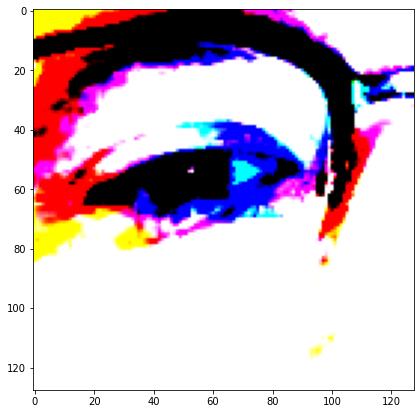

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


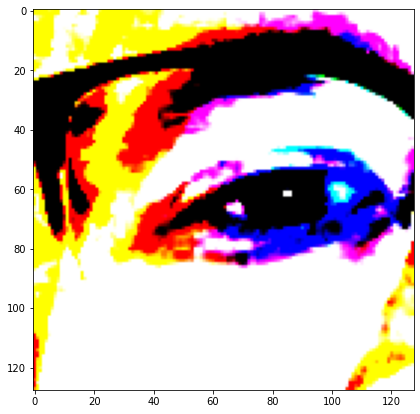

In [35]:
for features in valid_dataset.take(1): #reading first 1 values from the dataset
    l_eye = features[0]
    r_eye = features[1]
    
    print(f"lefteye shape: {l_eye[44][:,:,0].shape}")
    # print(f"righteye shape: {l_eye.shape}")
    # print(numpy.mean(l_eye[44][;;;0].numpy()))
    print(f"lefteye mean: {np.mean(l_eye[44][:,:,0])}")
    # print()
    
    plt.figure(figsize=(7, 7))
    plt.imshow(l_eye[44].numpy())
    plt.show()
    
    plt.figure(figsize=(7, 7))
    plt.imshow(r_eye[44].numpy())
    plt.show()

## Log Dataset

In [ ]:
%%time

print('test 1')

wandb.init(project="my-test-project1")


# wandb.init(project="test-project11", entity="eye-tracker-gsoc")

print('test 2')

ds = wandb.Artifact("tfrec_dataset", "dataset")

print('test 3')

train_table = wandb.Table(columns=[], data=[])

print('test 4')

for features in valid_dataset.take(1): #reading 1 batch from the dataset
    
    print('test 5')
    
    l_eye = features[0]
    r_eye = features[1]
    kps = features[2]
    out = features[3]

    train_table.add_column('l_eye', l_eye[:])
    
    print('test 6')
    
    train_table.add_column('r_eye', r_eye[:])
    train_table.add_column('kps', kps[:])
    train_table.add_column('out', out[:])
    
    
print('test 7')


ds['train_data'] = train_table

print('test 8')

ds.save()

print('test 9')

wandb.finish()

print('test 10')

test 1


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx512/Core/ipykernel/2020a/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
%%time
# Add training data
train_table.add_column('image', train_images[:log_train_samples])
# Add training label_id
train_table.add_column('label_id', train_labels[:log_train_samples])
# Add training class names
train_table.add_computed_columns(lambda ndx, row:{
    "images": wandb.Image(row["image"]),
    "class_names": configs['class_names'][str(row["label_id"])]
    })

# Add the table to the Artifact
ds['train_data'] = train_table

# Let's do the same for the validation data
valid_table = wandb.Table(columns=[], data=[])
valid_table.add_column('image', valid_images)
valid_table.add_column('label_id', valid_labels)
valid_table.add_computed_columns(lambda ndx, row:{
    "images": wandb.Image(row["image"]),
    "class_name": configs['class_names'][str(row["label_id"])]
    })
ds['valid_data'] = valid_table

# Save the dataset as an Artifact
ds.save()

# Finish the run
wandb.finish()